In [112]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

In [113]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [114]:
img_size = 512
vgg = tf.keras.applications.VGG16(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False

In [115]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G' (≈2 lines)
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    
    ### END CODE HERE
    
    return J_content

In [159]:
def compute_variation_loss(generated_image):
    a = tf.square(generated_image[:, :img_size-1, :img_size-1, :] - generated_image[:, 1:, :img_size-1, :])
    b = tf.square(generated_image[:, :img_size-1, :img_size-1, :] - generated_image[:, :img_size-1, 1:, :])
    J_variation = tf.reduce_sum(tf.pow(a + b, 1.25))
    return J_variation

In [160]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    ### START CODE HERE
    
    #(≈1 line)
    GA = tf.linalg.matmul(A, tf.transpose(A))
    
    ### END CODE HERE

    return GA

In [161]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1 / (4 * (n_H * n_W * n_C)**2) * tf.reduce_sum(tf.square(GS - GG))
    
    ### END CODE HERE
    
    return J_style_layer

In [162]:
vgg.get_layer('block2_conv2').output

<KerasTensor: shape=(None, 256, 256, 128) dtype=float32 (created by layer 'block2_conv2')>

In [163]:
STYLE_LAYERS = [
    ('block1_conv2', 1),
    ('block2_conv2', 1),
    ('block3_conv3', 1),
    ('block4_conv3', 1),
    ('block5_conv3', 1)]

In [164]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [165]:
@tf.function()
def total_cost(J_content, J_style, J_variation,  alpha = 0.025, beta = 5 / len(STYLE_LAYERS), variation_weight = 1):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = J_content * alpha + J_style * beta + J_variation * variation_weight
    
    ### START CODE HERE

    return J

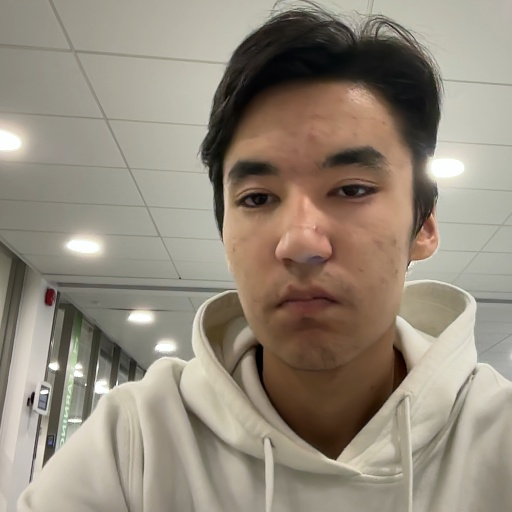

In [166]:
content_image_path = 'images/content/84f14fbe-b675-11ee-951f-1e592a5e1492.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((img_size, img_size))
content_image

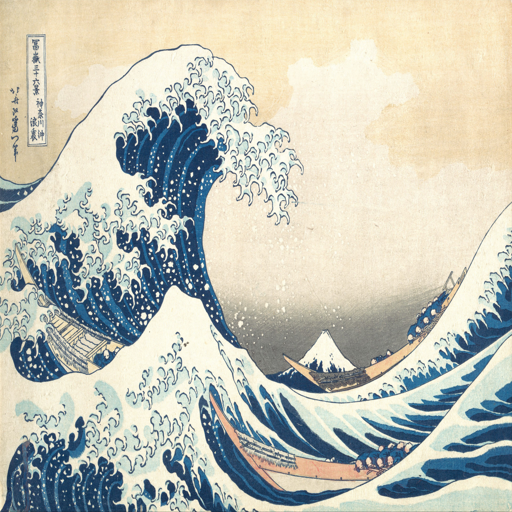

In [167]:
style_image_path = 'images/style/Tsunami_by_hokusai_19th_century.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((img_size, img_size))
style_image

In [168]:
content_image = np.array(Image.open(content_image_path).resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

In [169]:
style_image =  np.array(Image.open(style_image_path).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

In [170]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

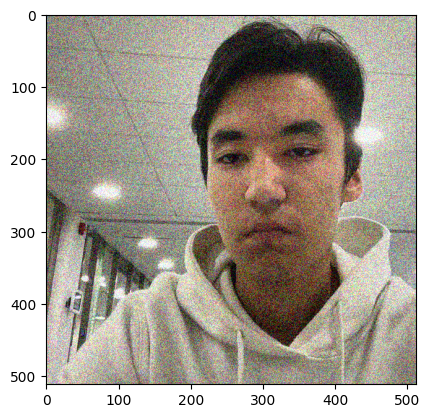

In [171]:
plt.imshow(generated_image.numpy()[0])

In [172]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [173]:
content_layer = [('block2_conv2', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [174]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [175]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [176]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [177]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [207]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.5)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)
        a_G = vgg_model_outputs(generated_image) 
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        
        J_variation = compute_variation_loss(generated_image)
        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, J_variation,  alpha = 0.025, beta = 5, variation_weight = 0)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [208]:
generated_image = tf.Variable(generated_image)

Epoch 0 


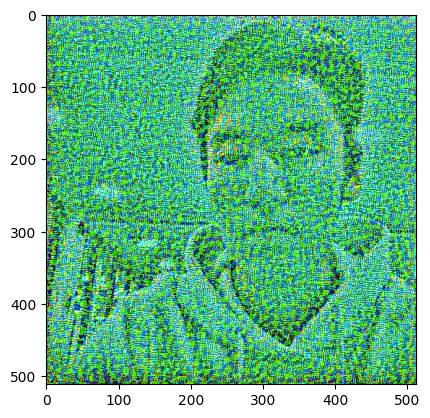

Epoch 25 


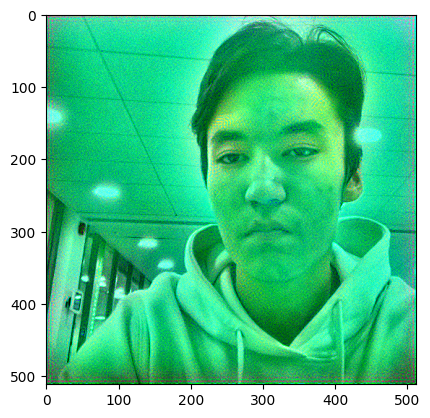

Epoch 50 


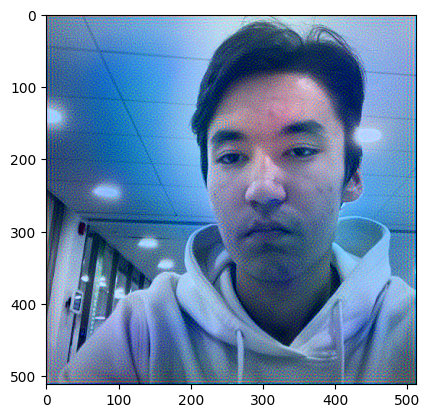

Epoch 75 


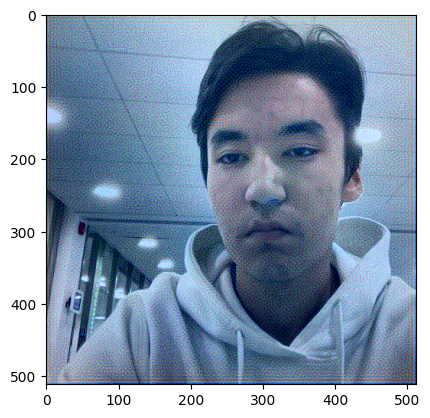

Epoch 100 


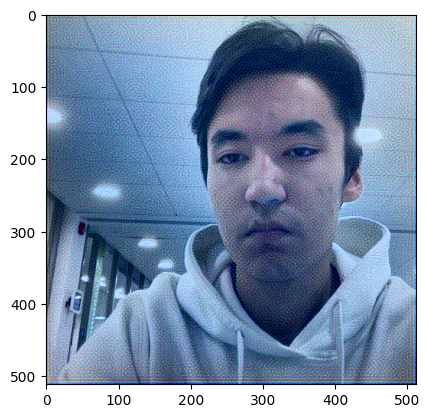

Epoch 125 


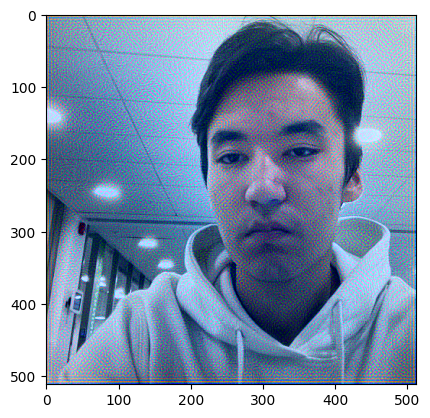

Epoch 150 


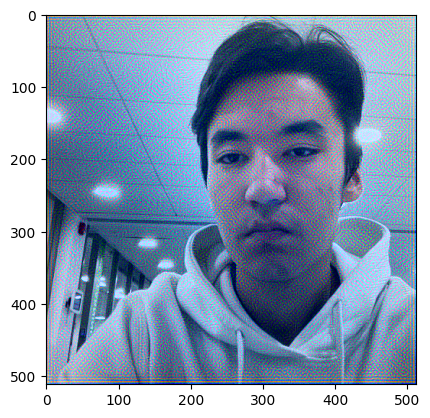

Epoch 175 


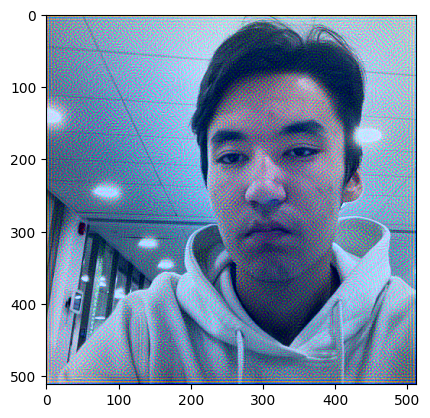

In [209]:
epochs = 200
for i in range(epochs):
    train_step(generated_image)
    if i % 25 == 0:
        print(f"Epoch {i} ")
    if i % 25 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"images/output/image_{i}.jpg")
        plt.show() 

In [ ]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [231]:
content_image = np.array(Image.open(content_image_path).resize((img_size, img_size)))

In [232]:
content_image.shape

(512, 512, 3)

In [233]:
content_image[:, :, 0] -= 103
content_image[:, :, 1] -= 116
content_image[:, :, 2] -= 123
content_image = content_image[:, :, ::-1]

In [234]:
content_image.shape

(512, 512, 3)

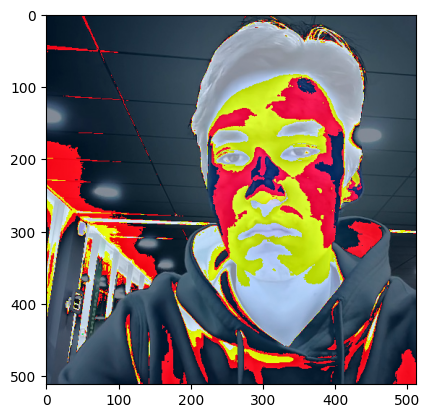

In [235]:
plt.imshow(content_image)

In [236]:
content_image = content_image[:, :, ::-1]
content_image[:, :, 0] += 103
content_image[:, :, 1] += 116
content_image[:, :, 2] += 123
content_image = np.clip(content_image, 0, 255).astype('uint8')

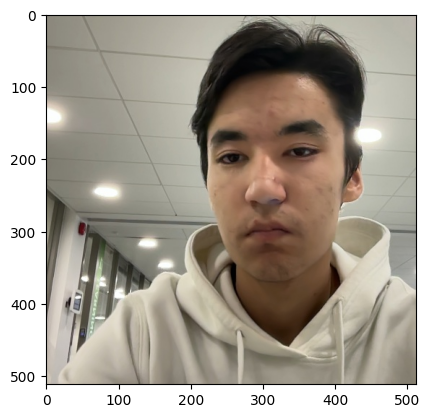

In [237]:
plt.imshow(content_image)